# Leaf Classification---Kaggle competition (Part II)

For this ipython notebook, I will investigate the problem about how to perform feature reductions. The investigation is developed as follows:

1. The correlation of features and how to visulize them
2. The PCA and feature reduction

## 1. The correlation of features and how to visulize them

Here, another thanks for the Author of the notebook: https://www.kaggle.com/asparago/3-basic-classifiers-and-features-correlation Federico C

### 1.1 Using Naive Bayes for revealing the feature correlation

In [88]:
import numpy as np
import scipy as sp
import pandas as pd
import tensorflow as tf

# Python visulization
import matplotlib.pyplot as plt
import seaborn as sns
import pyecharts as pchart
import matplotlib.image as mpimg 
import matplotlib.patches as mpatches
import matplotlib.gridspec as gridspec

## Modelling Algorithms
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB

## Model preprocess
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedShuffleSplit

# %matplotlib notebook
%config InlineBackend.figure_format = 'retina'

pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

In [2]:
## Import dataset and define the train and test set

import os

## PATH name definition
PATH = os.getcwd()
IMAGES = PATH + "/images"
TRAIN = PATH + "/train.csv"
TEST = PATH + "/test.csv"
SAMPLE = PATH + "sample_submission.csv"

## Get the dataset from the file
df = pd.read_csv(TRAIN, sep = ',')
df_test = pd.read_csv(TEST, sep = ',')

## Label encoder
label_fitter = LabelEncoder().fit(df['species'])
labels = label_fitter.transform(df['species'])
test_ids = df_test.id

## Now let's drop the unimportant features
df = df.drop(['species', 'id'], axis = 1)
df_test = df_test.drop(['id'], axis = 1)

## Using stratifiedShuffleSplit to split train and test dataset
sss = StratifiedShuffleSplit(n_splits=10, test_size=0.2, random_state=0)
sss.get_n_splits(df, labels)
      
for train_index, test_index in sss.split(df, labels):
#     print("TRAIN:", train_index, "TEST:", test_index)
    X_train, X_test = df.iloc[train_index], df.iloc[test_index]
    Y_train, Y_test = labels[train_index], labels[test_index]

In [89]:
## Define Naive Bayes
NBC = GaussianNB()

NBC.fit(X_train, Y_train)

name = NBC.__class__.__name__

train_predictions = NBC.predict(X_test)
acc_train = accuracy_score(Y_train, NBC.predict(X_train))
acc = accuracy_score(Y_test, train_predictions)

print ("The training set accuracy is: " + str(acc_train*100)+'%')
print ("The test set accuracy is: " + str(acc*100)+'%')

The training set accuracy is: 99.87373737373737%
The test set accuracy is: 55.05050505050505%


**Conclusion:**

These overfitting makes sense, this is a typical strong correlation induced overfitting. This is purely due to the fact that the there are some features that strongly correlated between each other. 

### 1.2 The calculation of Pearson coefficient

The features are evenly distributed among the three big categories

In [4]:
import re

## Check the categories in the columns
# nameset = set(re.match(r'([a-z]+)([0-9]+)',i).groups()[0] for i in df.columns)

## Alternative solutions
nameset = np.unique([re.match(r'([a-z]+)([0-9]+)',i).groups()[0] for i in df.columns])

print (nameset)

['margin' 'shape' 'texture']


In [5]:
## build category names:

margin_names = [name for name in df.columns if re.match(r'([a-z]+)([0-9]+)',name).groups()[0] == nameset[0]]
shape_names = [name for name in df.columns if re.match(r'([a-z]+)([0-9]+)',name).groups()[0] == nameset[1]]
texture_names = [name for name in df.columns if re.match(r'([a-z]+)([0-9]+)',name).groups()[0] == nameset[2]]

In [6]:
import Pdprint as pp

## Build Pearson number within and out category

# 1. Within class
margin_pearson = [pp.Pearson(df[margin_names[i]], df[margin_names[i+1]]) for i in range(len(margin_names)-1)]
margin_x = [0]*len(margin_pearson)
shape_pearson = [pp.Pearson(df[shape_names[i]], df[shape_names[i+1]]) for i in range(len(shape_names)-1)]
shape_x = [1]*len(shape_pearson)
texture_pearson = [pp.Pearson(df[texture_names[i]], df[texture_names[i+1]]) for i in range(len(texture_names)-1)]
texture_x = [2]*len(texture_pearson)

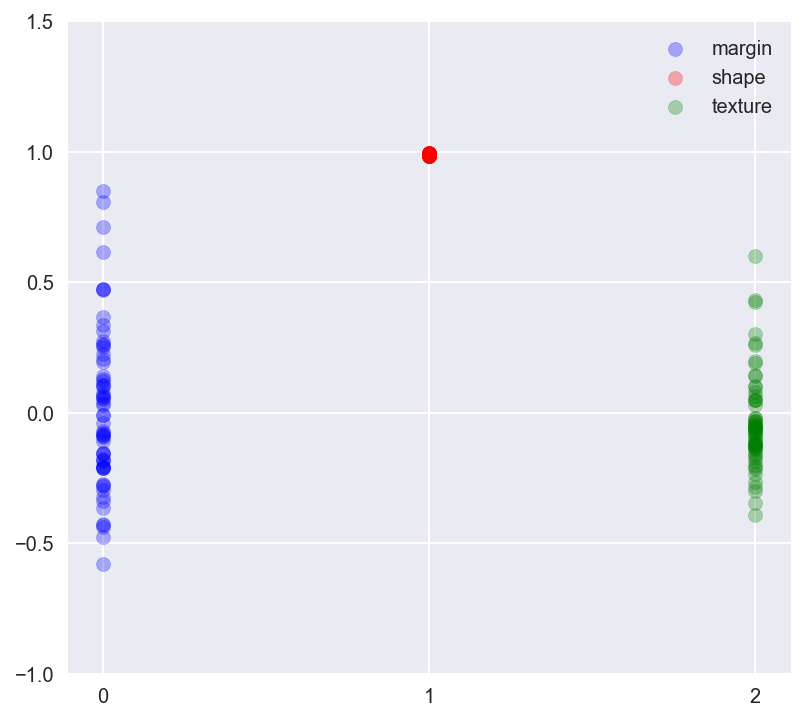

In [62]:
## plot the distribution of Pearson number
sns.set()  ## set seaborn style

fig, ax = plt.subplots(figsize = (9,6))

ax.scatter(margin_x, margin_pearson, color = 'blue', alpha= 0.3, label = "margin")
ax.scatter(shape_x, shape_pearson, color = 'red', alpha = 0.3, label = "shape")
ax.scatter(texture_x, texture_pearson, color = 'green', alpha = 0.3, label = "texture")
ax.legend()

## set axes geometry
ax.set_ylim(-1,1.5)
ax.set_xticks([0,1,2])
ax.set_label(['margin, shape, texture'])

ax.set_aspect(0.8)
plt.show()

In [25]:
## randomly pick up the elements

def RandomGenerate(prefix, start, end, size=10):
    """
    This function will generate an array of string, which the prefix is givien by the prefix.
    The random number is from start(inclusive) to end(exclusive).
    
    Parameters:
    -----------
    prefix: str type input
    start: int, starting number of an array (inclusive)
    end:   int, ending number of an array (exclusive)
    size:  the size of the array
    
    Return:
    -------
    An list of string, in which the element takes the form: "prefix"+number
    """
    
    import random
    
    randlist = random.sample(range(start, end), size)
    randlist.sort()
    
    return list(map(lambda x: prefix + str(x), randlist))

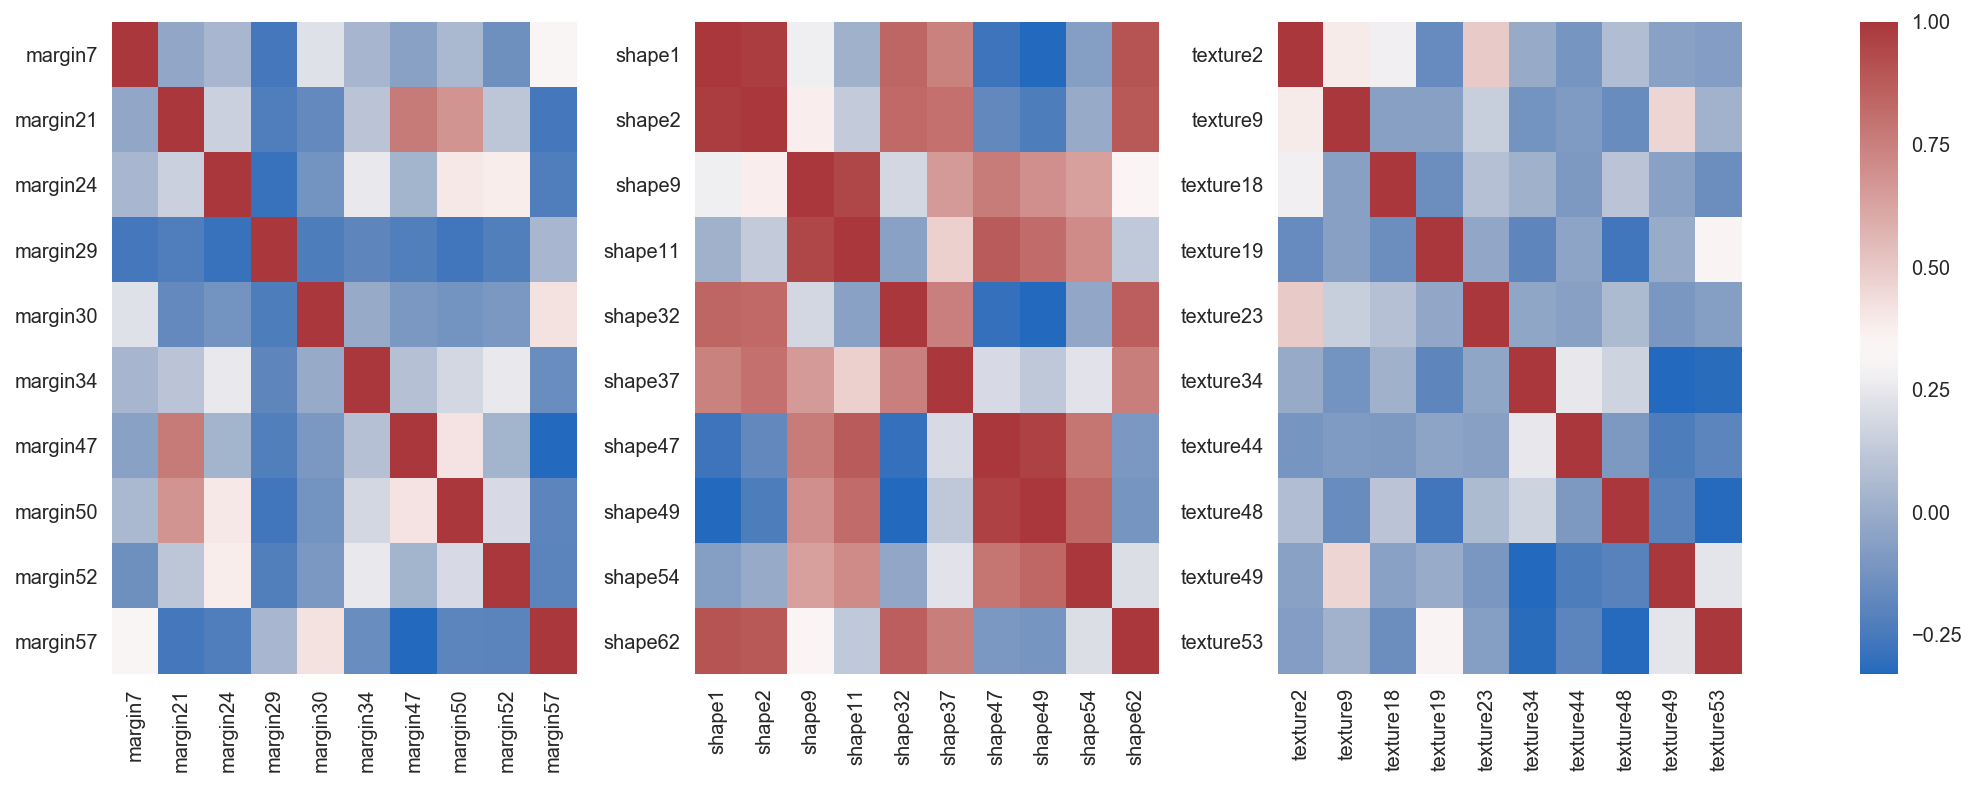

In [68]:
## calculate the pairwise correlation within categories

margin_pair = df[RandomGenerate('margin', 1, 65)].corr()
shape_pair = df[RandomGenerate('shape', 1, 65)].corr()
texture_pair = df[RandomGenerate('texture', 1, 65)].corr()


f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4,figsize=(16,6),
            gridspec_kw={'wspace':0.33,'width_ratios':[1,1,1,0.08]})
ax1.get_shared_y_axes().join(ax2,ax3)
g1 = sns.heatmap(margin_pair,cmap="vlag",cbar=False,ax=ax1)
g2 = sns.heatmap(shape_pair,cmap="vlag",cbar=False,ax=ax2)
g3 = sns.heatmap(texture_pair,cmap="vlag",ax=ax3, cbar_ax=axcb)


plt.show()


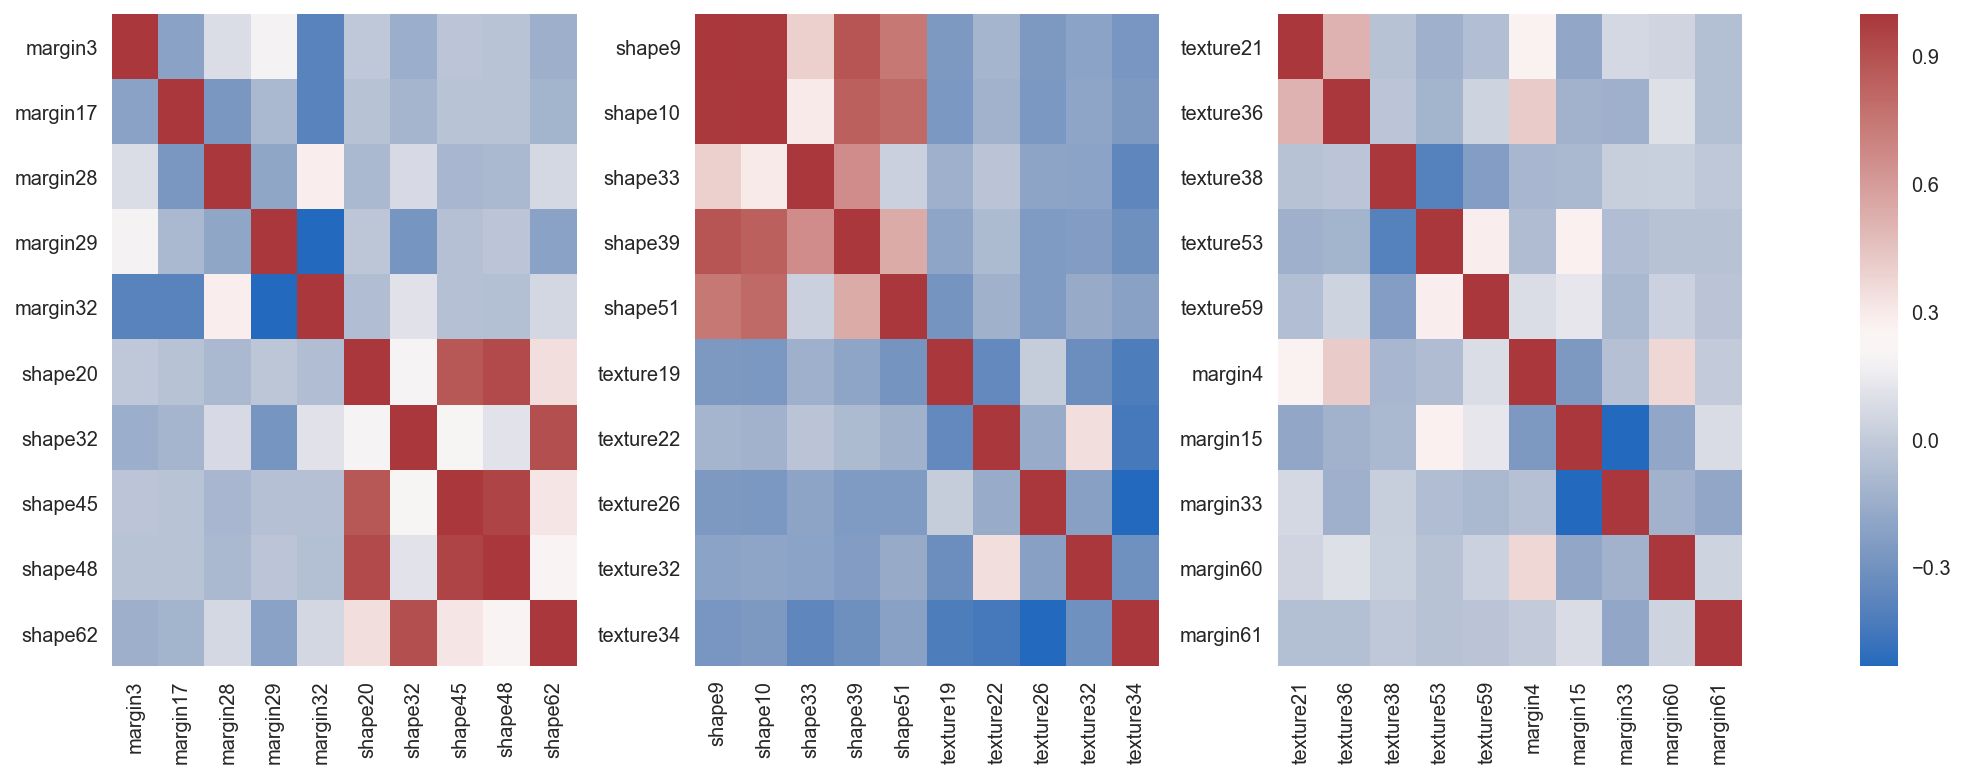

In [81]:
## The correlation matrix between different categories

## build list
margin_list = RandomGenerate('margin', 1, 65, size=5)
shape_list = RandomGenerate('shape', 1, 65, size=5)
texture_list = RandomGenerate('texture', 1, 65, size=5)

## extend to new list
margin_list.extend(RandomGenerate('shape', 1, 65, size=5))
shape_list.extend(RandomGenerate('texture', 1, 65, size=5))
texture_list.extend(RandomGenerate('margin', 1, 65, size=5))


## calculate the correlation
margin_shape = df[margin_list].corr()
shape_texture = df[shape_list].corr()
margin_texture = df[texture_list].corr()

## plot it

f,(ax1,ax2,ax3, axcb) = plt.subplots(1,4,figsize=(16,6),
            gridspec_kw={'wspace':0.33,'width_ratios':[1,1,1,0.08]})
ax1.get_shared_y_axes().join(ax2,ax3)
g1 = sns.heatmap(margin_shape,cmap="vlag",cbar=False,ax=ax1)
g2 = sns.heatmap(shape_texture,cmap="vlag",cbar=False,ax=ax2)
g3 = sns.heatmap(margin_texture,cmap="vlag",ax=ax3, cbar_ax=axcb)


plt.show()

**Conclusion:**


From these three set of pictures, everything is quite clear right now. The correlation between each category is quite small, so that we can confidently treat each category as orthognal to each other. However, the shpae feature is not really useful for classification, it is highly correlated within this data group. so now a possible data selection procedure is necessary.

## 2. PCA for feature selection

In [83]:
from sklearn.decomposition import PCA

## PCA builder
pca = PCA(n_components = 'mle', svd_solver = 'full')

pca.fit(X_train)

X_train_pca = pca.transform(X_train)
X_test_pca = pca.transform(X_test)

In [90]:
## Recalculate using Bayes method


## Define Naive Bayes
NBC = GaussianNB()

NBC.fit(X_train_pca, Y_train)

name = NBC.__class__.__name__

train_predictions = NBC.predict(X_test_pca)
acc_train = accuracy_score(Y_train, NBC.predict(X_train_pca))
acc = accuracy_score(Y_test, train_predictions)

print ("The training set accuracy is: " + str(acc_train*100)+'%')
print ("The test set accuracy is: " + str(acc*100)+'%')

The training set accuracy is: 100.0%
The test set accuracy is: 93.93939393939394%


**Conclusion**

Wonderful result!! We successfully solved the overfitting problem

In [99]:
X_train_margin_pca = pca.fit(X_train[[x for x in df.columns if 'shape' in x]])
X_train_margin_pca = pca.transform(X_train[[x for x in df.columns if 'shape' in x]])

In [100]:
X_train_margin_pca.shape

(792, 55)

In [21]:
a = np.array([4,4,3,3,3,2,2,3])

b = np.array([2,3,4])

In [22]:
np.searchsorted(b, a)

array([2, 2, 1, 1, 1, 0, 0, 1])

In [18]:
np.array(list(map(lambda x: 0 if x==3 else 1,a)))

array([0, 1, 1, 0, 0, 0])

In [26]:
RandomGenerate('margin', 1,65,10)

['margin2',
 'margin6',
 'margin8',
 'margin10',
 'margin14',
 'margin18',
 'margin25',
 'margin51',
 'margin55',
 'margin62']